# Chapter 5

In [2]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

#from aesara import shared
#from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In [4]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [5]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [6]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

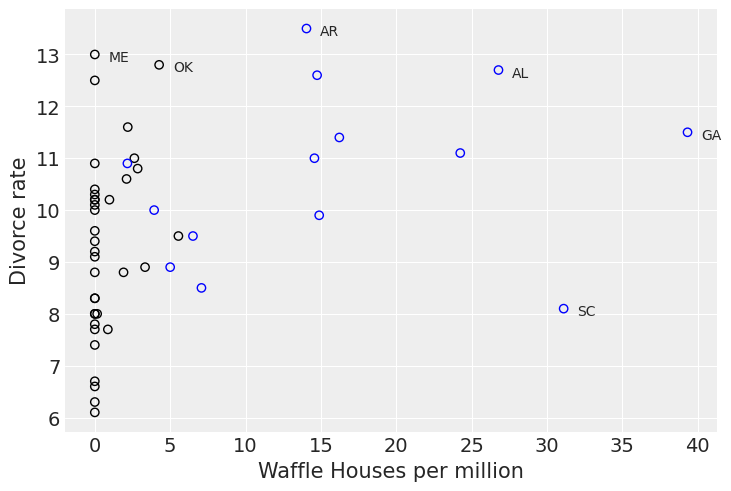

In [7]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

Text(0.5, 0, 'Median age marriage')

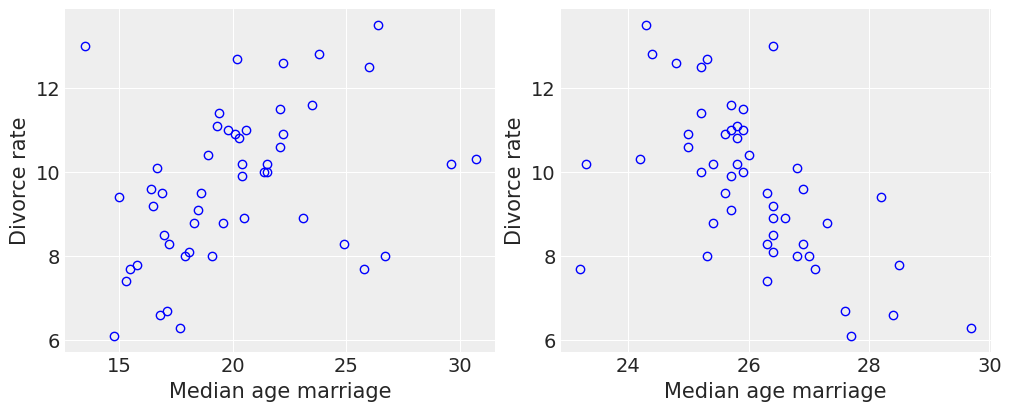

In [8]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Median age marriage")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

#### Code 5.1

In [9]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [10]:
data["MedianAgeMarriage"].std()

np.float64(1.2436303013880823)

#### Code 5.3

In [11]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Sampling: [a, bA, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


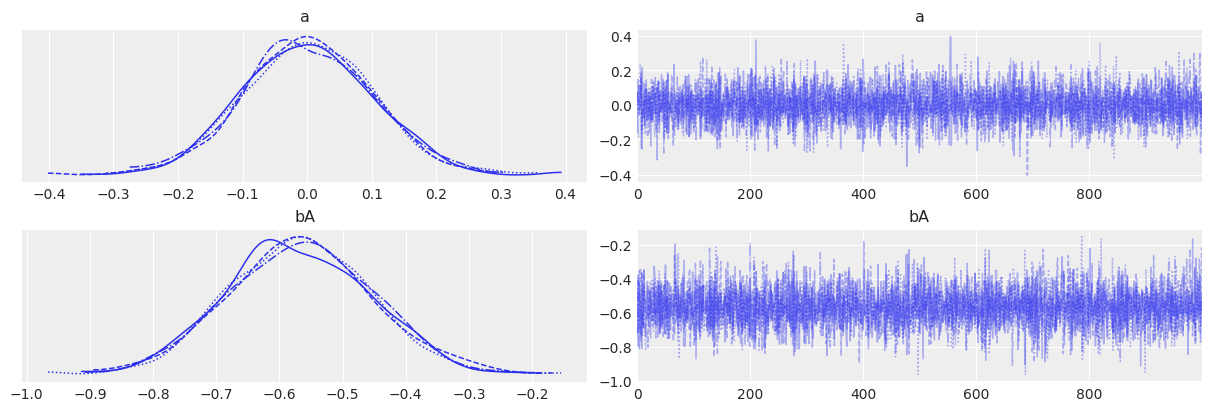

In [12]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

#### Code 5.4

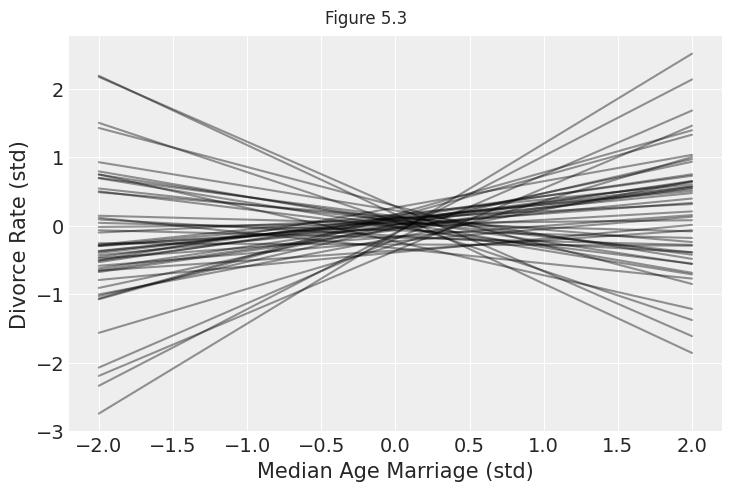

In [13]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

#### Code 5.5

In [14]:
m_5_1_trace.posterior["bA"].shape

(4, 1000)

In [15]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None, None, 10))
m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std

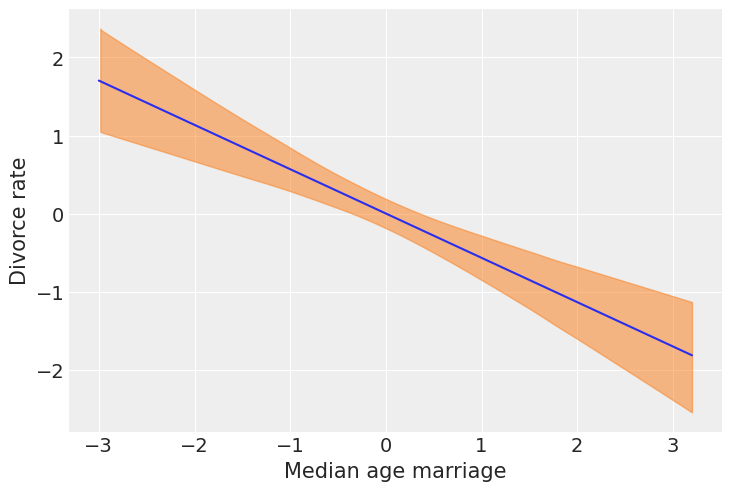

In [16]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

#### 5.6

In [17]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Sampling: [a, bM, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


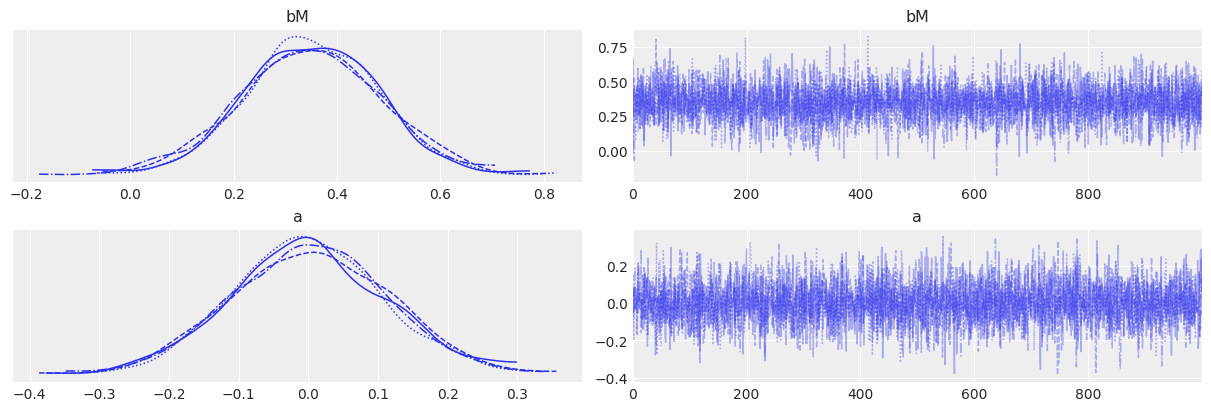

In [18]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

#### 5.7
Credit to [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/05_the_many_variables_and_the_spurious_waffles#Code-5.7)


Author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other. 

How do we understand all this ?

He explains that here we may want to think **causally**. 

Few interesting assumptions (or rather deductions) -

* a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

* b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

* c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D

M -> D

A -> M

and yet another way is to use **DAG** (Directed Acyclic Graphs)


C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


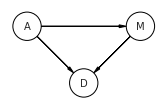

In [18]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**.

**MEDIATION** - Let's say that **A** did not directly influence **D**; rather it did it via **M**. This type of relationship is called *Mediation*


Author raises many interesting questions here. He asks if there is indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a **spurious** correlation between marriage rate and divorce rate


#### 5.8

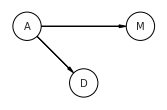

In [19]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

We can get the joint probability distribution implied by our causal graphical model using

In [20]:
print(dag5_2.get_distribution())

P(A)P(D|A)P(M|A)


To see the Conditional Independencies, we can use one of the following two snippets. The explanation is that **M** and **D** are not independent, unless we condition on **A** when they become conditionally independent.

In [21]:
dag5_2.get_all_independence_relationships()

[('D', 'M', {'A'})]

In [22]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


#### 5.9

Checking the independencies in the first DAG

In [23]:
DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

Executing above cell should not display anything as in the DAG1 (where all nodes are connected to each other) there are no conditional independencies.

#### 5.10

In [19]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"].values + bA * data["MedianAgeMarriage_std"].values
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [20]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.003,0.101,-0.185,0.185,0.002,0.002,4065.0,2985.0,1.0
bM,-0.063,0.160,-0.370,0.225,0.003,0.002,2487.0,2687.0,1.0
bA,-0.612,0.157,-0.900,-0.312,0.003,0.002,2604.0,2596.0,1.0
sigma,0.827,0.087,0.674,0.992,0.002,0.001,3271.0,2468.0,1.0


#### 5.11

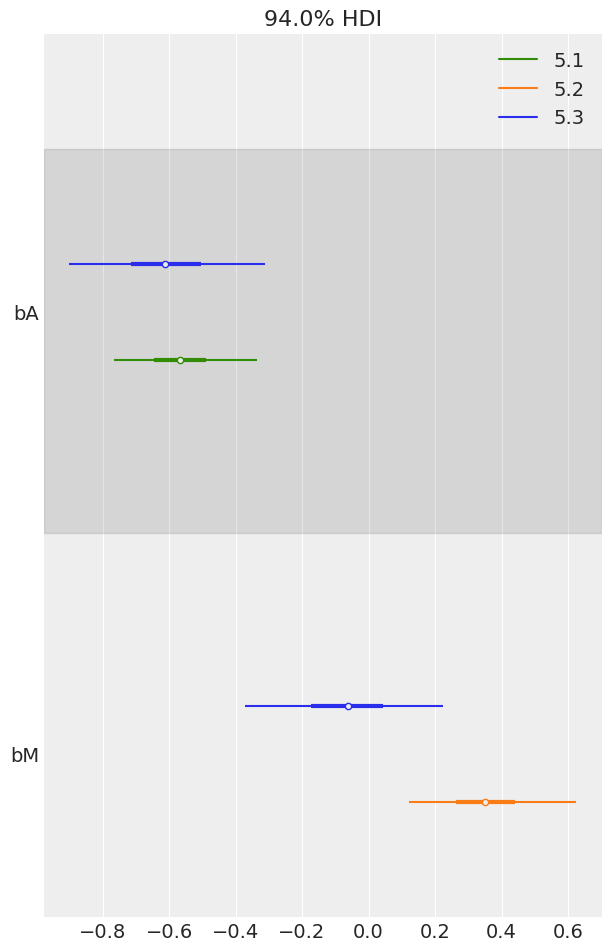

In [21]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True,
);

#### 5.12

In [22]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

#### 5.13

In [23]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"].values)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Sampling: [Marriage_std, a, bAM, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


#### 5.14

In [24]:
mu_m_5_4_mean = m_5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m_5_4_mean

#### 5.15
We can skip most of the code with the posterior predictive plot functionality in pymc

In [25]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(m_5_3_trace, var_names=["mu", "divorce_rate_std"])


mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

Sampling: [divorce_rate_std]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

#### 5.16

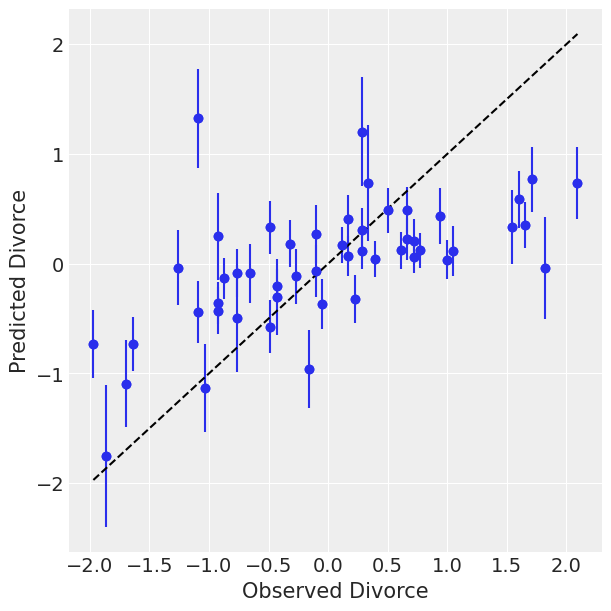

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

#### 5.17

#### 5.18

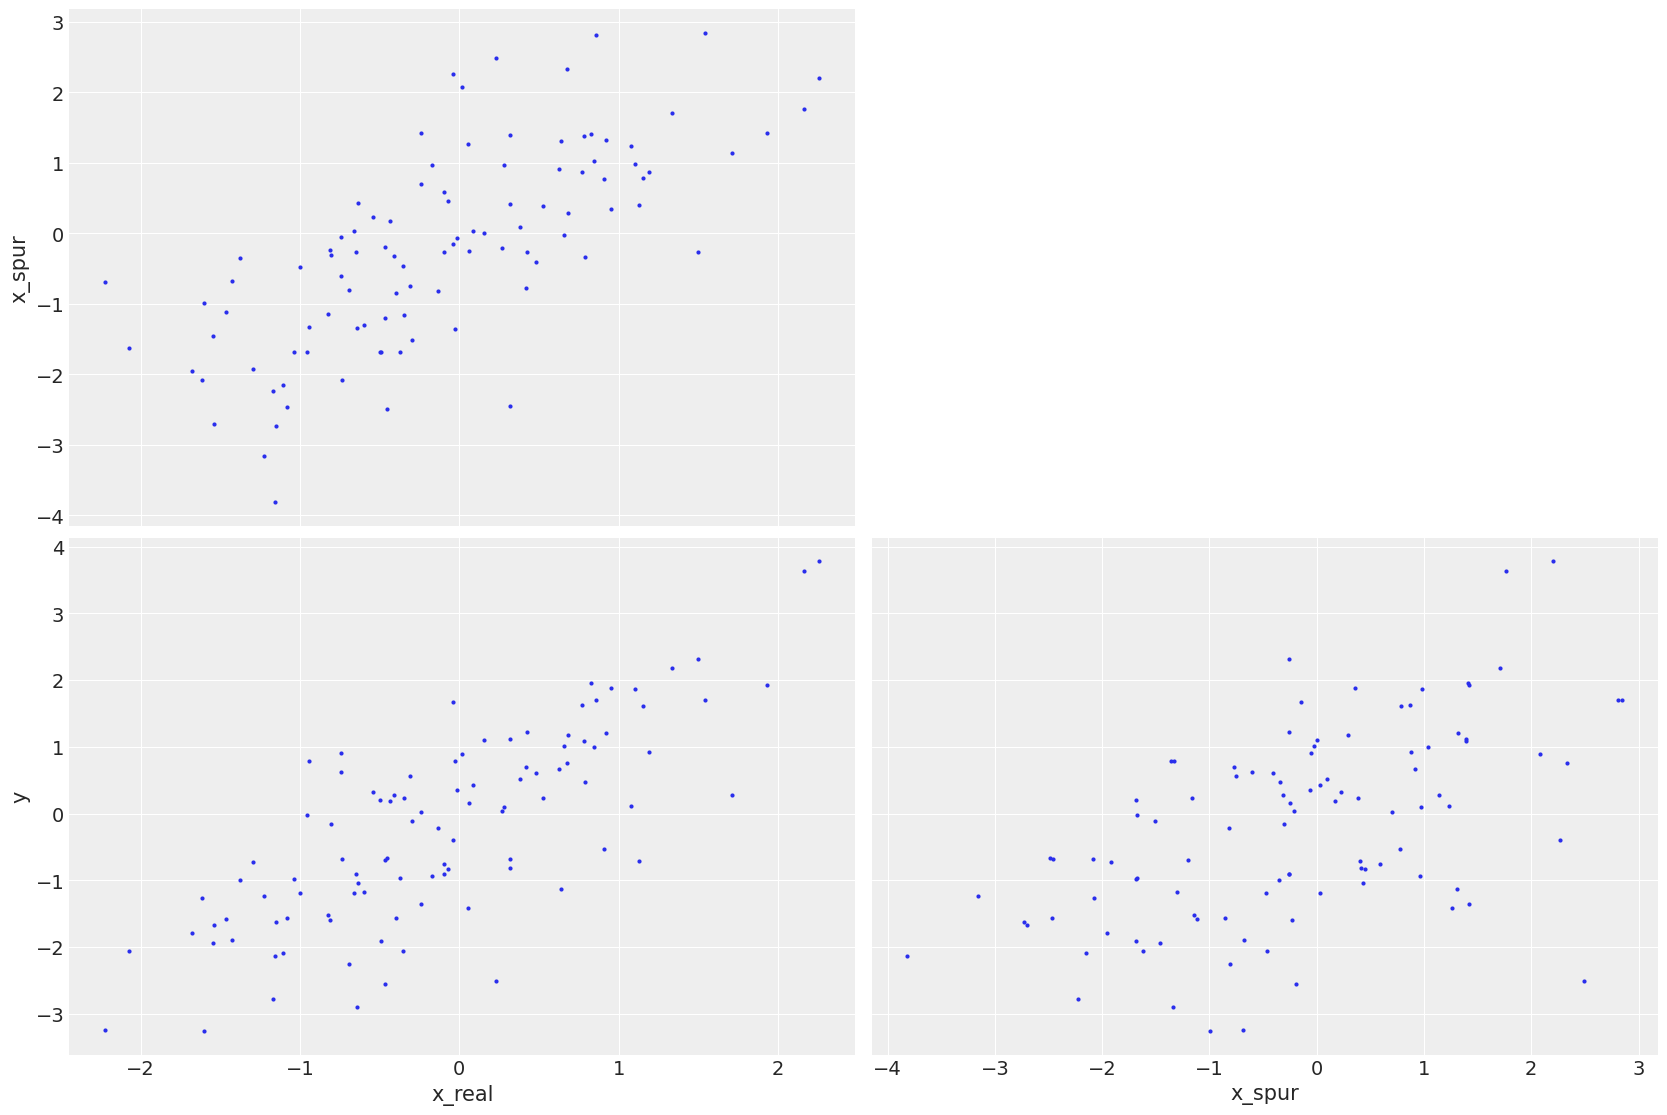

In [27]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

#### 5.19

In [32]:
from pytensor import shared

In [33]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Aesara shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
#marriage_shared = data["Marriage_std"].values
age_shared = shared(data["MedianAgeMarriage_std"].values)
#age_shared = data["MedianAgeMarriage_std"].values

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"].values)

    m5_3_A_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.


#### 5.20

In [34]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

#### 5.21

In [35]:
# With PyMC we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

#### 5.22

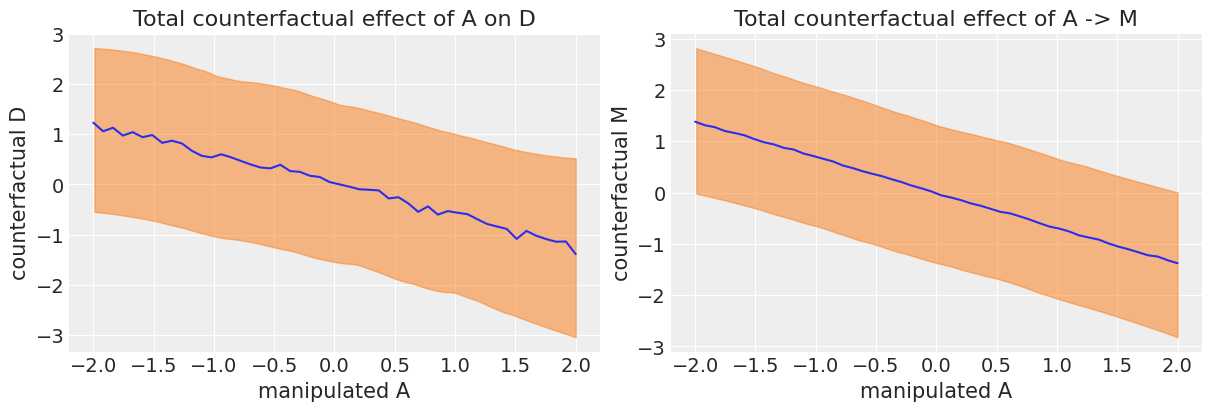

In [36]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3_M_marriage.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3_M_marriage.posterior_predictive["marriage"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

#### 5.23

In [37]:
# We're setting this to 50 to match the shape of our input
A_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24

age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# Average first and last column and take difference
(
    m5_3_M_ppc.posterior_predictive["divorce"][:, -1].mean()
    - m5_3_M_ppc.posterior_predictive["divorce"][:, 0].mean()
)

Sampling: [divorce, marriage]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<xarray.DataArray 'divorce' ()> Size: 8B
array(-0.15796198)

#### 5.24

In [38]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

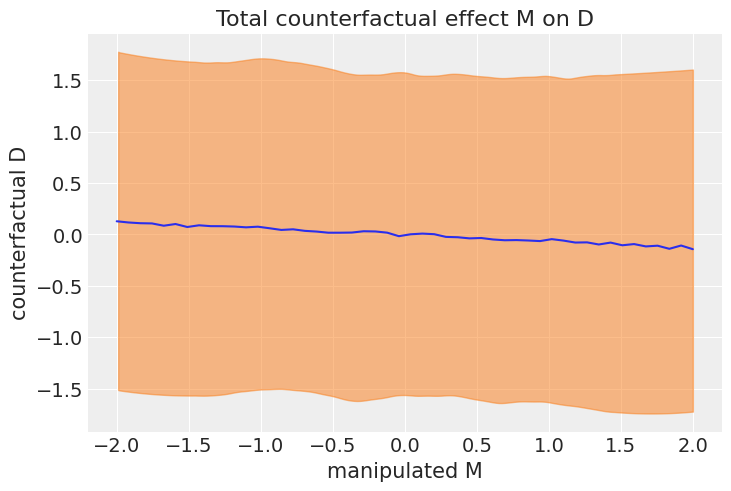

In [39]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc.posterior_predictive["divorce"], ax=ax)
ax.plot(
    marriage_counter_factual_x,
    m5_3_M_ppc.posterior_predictive["divorce"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

#### 5.25

In [43]:
A_seq = np.linspace(-2, 2, 30)

#### 5.26

In [44]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_m", "aM", "bAM"]
    )

In [45]:
marriage_mu_counterfactual = np.outer(
    m5_3_M_marriage.posterior_predictive["aM"] + m5_3_M_marriage.posterior_predictive["bAM"], A_seq
)
marriage_mu_counterfactual.shape

(4000, 30)

In [46]:
mu = marriage_mu_counterfactual.T
sigma = az.extract_dataset(m5_3_M_marriage.posterior_predictive["sigma_m"]).to_array()
M_sim = stats.norm(loc=mu, scale=sigma).rvs()
M_sim.shape

(30, 4000)

#### 5.27

In [47]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma", "bM", "bA", "a"]
    )

In [48]:
D_sim = np.zeros((30, 4000))
a = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["a"]).to_array())
bM = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bM"]).to_array())
bA = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bA"]).to_array())
sigma = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["sigma"]).to_array())

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA * age_counterfactual + bM * M_sim[i, :]
    samples = stats.norm(divorce_mu_counterfactual, sigma).rvs()
    D_sim[i, :] = samples

#### 5.28

In [40]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.29

In [41]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

#### 5.30

In [42]:
# This is meant to fail!
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"].values)

    K = pm.Normal("K", mu, sigma, observed=d["K"].values)

    m5_5_draft_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(-0.59301437), 'bN': array(0.73677723), 'a': array(-0.00591686)}

Logp initial evaluation results:
{'sigma': np.float64(-1.15), 'bN': np.float64(-1.19), 'a': np.float64(-0.92), 'K': np.float64(nan)}
You can call `model.debug()` for more details.

#### 5.32

In [43]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

#### 5.32

In [44]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

#### 5.33

In [45]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


#### 5.34

In [50]:
xseq = np.array([-2, 2])
shared_N = shared(xseq)

with pm.Model() as m5_5_predict:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma)  # <- no observed!

    prior_pred = pm.sample_prior_predictive()

Sampling: [K, a, bN, sigma]


In [52]:
#xseq = [-2, 2]
#shared_N.set_value(np.array(xseq))
#with m5_5_draft:
with m5_5_predict:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

Sampling: [K, a, bN, sigma]


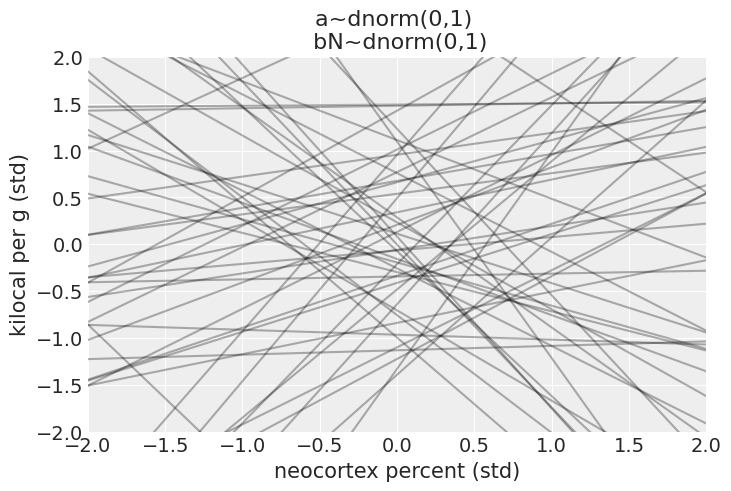

In [58]:
fig, ax = plt.subplots()

#ppr_K = m5_5_draft_prior_predictive.prior_predictive["K"].mean(dim=["chain"])
ppr_K = m5_5_draft_prior_predictive.prior["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.35

In [59]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample()

m5_5_data = az.extract_dataset(m5_5_trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [61]:
with pm.Model() as m5_5_predict2:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma)

    m5_5_trace = pm.sample()

    prior_pred = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a, K]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 313 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [K, a, bN, sigma]


In [62]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5_predict2:
    m5_5_prior_predictive = pm.sample_prior_predictive()

Sampling: [K, a, bN, sigma]


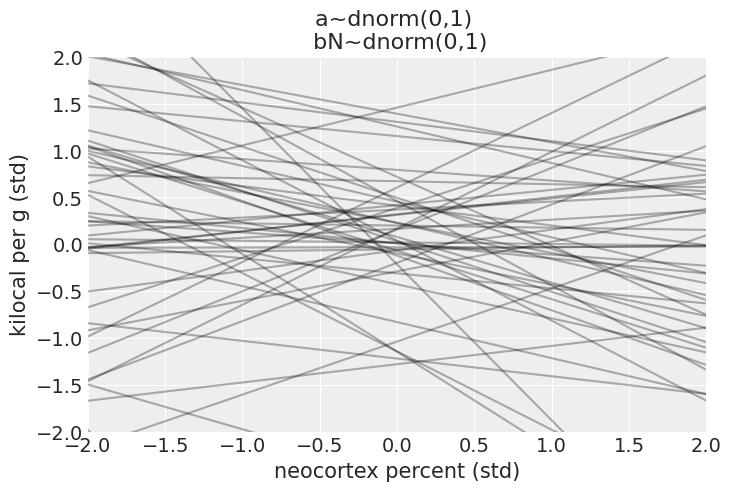

In [63]:
fig, ax = plt.subplots()

ppr_K = m5_5_prior_predictive.prior["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.36

In [64]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.010,0.206,-0.350,0.417,0.009,0.007,530.0,431.0,1.02
bN,-0.004,0.477,-0.924,0.906,0.013,0.011,1268.0,1710.0,1.02
sigma,1.207,0.978,0.165,3.038,0.114,0.029,23.0,31.0,1.12


#### 5.37

Sampling: []


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

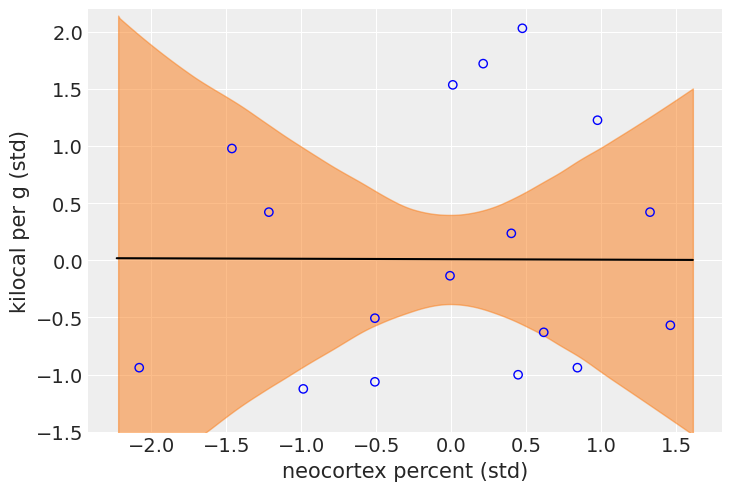

In [65]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"])

mu_ppd = m5_5_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.38

In [66]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.extract_dataset(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.294,0.240,-0.747,0.152,0.003,0.004,5347.0,2960.0,1.0
a,0.044,0.152,-0.250,0.312,0.002,0.002,5227.0,3321.0,1.0
sigma,1.056,0.198,0.722,1.435,0.003,0.004,4887.0,2875.0,1.0


#### 5.39

In [67]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.extract_dataset(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, bM, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 87 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.061,0.153,-0.232,0.342,0.001,0.001,34882.0,28941.0,1.0
bN,0.382,0.256,-0.092,0.871,0.002,0.001,27024.0,26960.0,1.0
bM,-0.513,0.270,-1.021,-0.007,0.002,0.001,25532.0,25789.0,1.0
sigma,0.970,0.190,0.655,1.329,0.001,0.001,28332.0,25998.0,1.0


#### 5.40

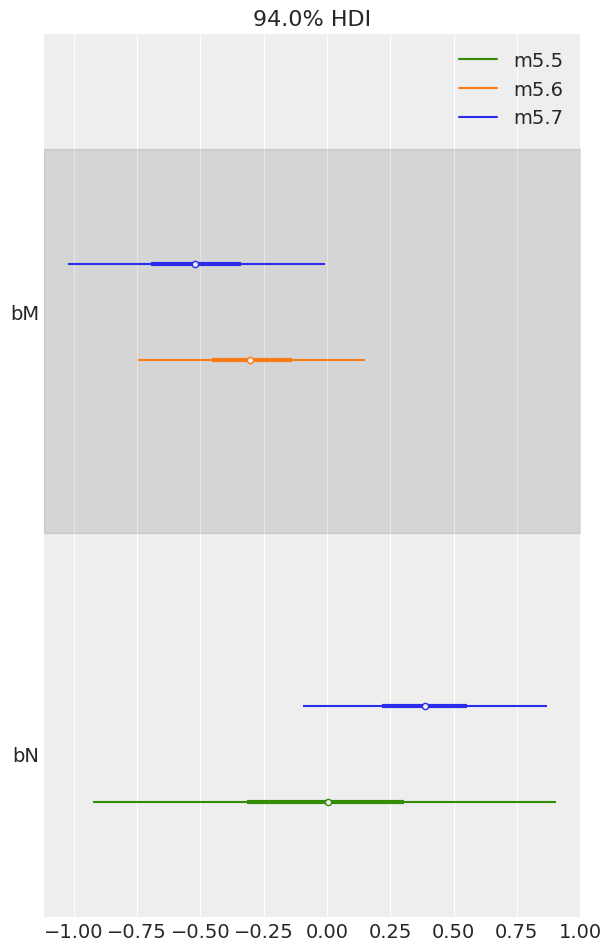

In [68]:
az.plot_forest(
    [m5_7_trace, m5_6_trace, m5_5_trace],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);

#### 5.41
This code actually produces right plot Confirned from Professor McElreath that the book text is mistaken.

Sampling: []


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

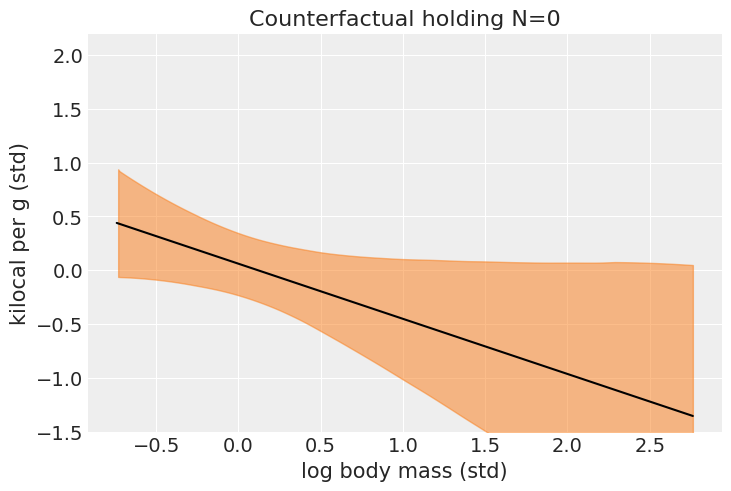

In [69]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])

mu_ppd = m5_7_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

#### 5.42

In [70]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

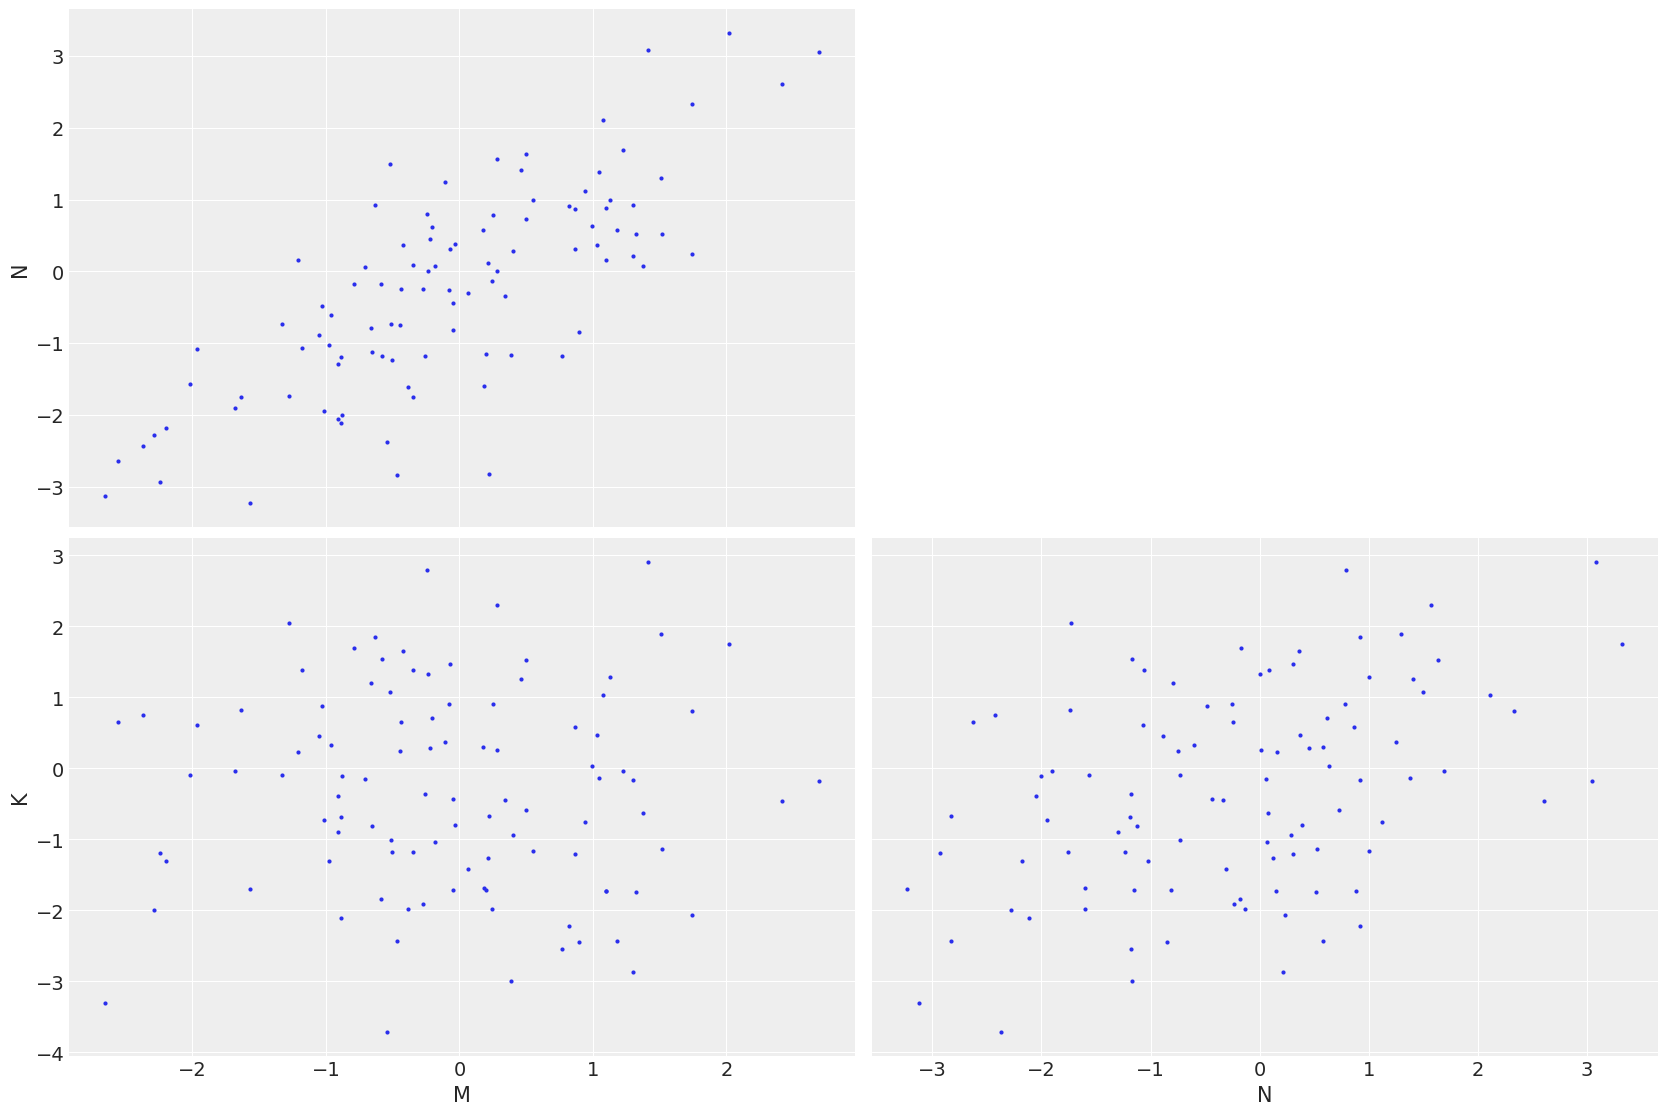

In [71]:
# Professor McElreath suggests viewing the pair plots
az.plot_pair({"M": M, "N": N, "K": K});

#### 5.43

In [72]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

#### 5.45

In [73]:
d = pd.read_csv(os.path.join("Data", "Howell1.csv"), delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### 5.46

In [74]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_female,177.658,19.204,143.761,214.045
mu_male,176.950,21.954,134.465,216.643


#### 5.47

In [76]:
sex = d["male"].values
sex

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,

#### 5.48

In [77]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 247 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.886,1.625,131.891,138.037,0.021,0.025,6111.0,2883.0,1.0
mu[1],142.558,1.687,139.386,145.565,0.023,0.026,5623.0,2925.0,1.0
sigma,27.428,0.822,25.810,28.866,0.010,0.013,6269.0,3150.0,1.0


#### 5.49

In [78]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)

    # With PyMC it's easier just to create a deterministic that includes both values
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 206 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.917,1.619,132.002,138.144,0.020,0.026,6523.0,3194.0,1.0
mu[1],142.564,1.682,139.433,145.687,0.021,0.026,6270.0,3289.0,1.0
sigma,27.416,0.827,25.814,28.904,0.010,0.014,6302.0,2621.0,1.0
diff,-7.647,2.343,-11.817,-3.038,0.028,0.035,6907.0,3193.0,1.0


#### 5.50

In [74]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.51

In [75]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

#### 5.52

In [76]:
d["clade_id"].max() + 1

4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


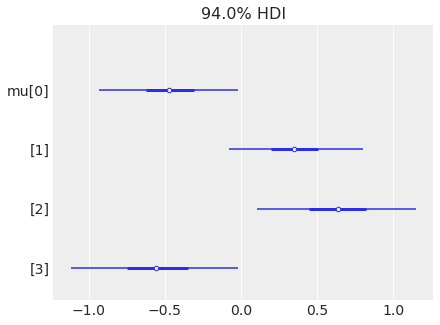

In [77]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=[d["clade_id"].max() + 1])
    K = pm.Normal("K", mu[d["clade_id"].values], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);

#### 5.53

In [78]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

#### 5.54

In [79]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=[d["house"].max() + 1])
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=[d["clade_id"].max() + 1])
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_house, mu_clade]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.362,0.290,-0.907,0.198,0.005,0.004,3159.0,3182.0,1.0
mu_clade[1],0.363,0.295,-0.205,0.908,0.005,0.004,3188.0,3222.0,1.0
mu_clade[2],0.557,0.314,-0.013,1.179,0.005,0.004,3375.0,2916.0,1.0
mu_clade[3],-0.466,0.325,-1.076,0.143,0.005,0.004,3786.0,2837.0,1.0
mu_house[0],0.123,0.324,-0.469,0.729,0.005,0.005,3503.0,2977.0,1.0
mu_house[1],-0.357,0.286,-0.885,0.181,0.005,0.004,3087.0,2976.0,1.0
mu_house[2],0.049,0.285,-0.458,0.602,0.005,0.004,3304.0,2820.0,1.0
mu_house[3],0.288,0.325,-0.372,0.856,0.005,0.004,3569.0,3305.0,1.0


5H2.  Assuming that the DAG for the divorce example is indeed M → A → D, fit a new model and use it to estimate the counterfactual effect of halving a State’s marriage rate M. Use the counterfactual example from the chapter (starting on page 140) as a template.

In [90]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series
    
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])
data["Divorce_std"] = standardize(data["Divorce"])

marriage_shared = shared(data["Marriage_std"].values)

with pm.Model() as m5_3_H:
    # Step 1: A ~ M
    sigma_A = pm.Exponential("sigma_A", 1)
    bMA = pm.Normal("bMA", 0, 0.5)
    aA = pm.Normal("aA", 0, 0.2)
    mu_A = pm.Deterministic("mu_A", aA + bMA * marriage_shared)
    A_obs = pm.Deterministic("A_obs", mu_A)  # <-- add this line
    A_like = pm.Normal("A_like", mu_A, sigma_A, observed=data["MedianAgeMarriage_std"])
    
    # Step 2: D ~ A
    sigma_D = pm.Exponential("sigma_D", 1)
    bAD = pm.Normal("bAD", 0, 0.5)
    aD = pm.Normal("aD", 0, 0.2)
    mu_D = pm.Deterministic("mu_D", aD + bAD * mu_A)
    D_obs = pm.Normal("D_obs", mu_D, sigma_D, observed=data["Divorce_std"])
    
    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_A, bMA, aA, sigma_D, bAD, aD]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.


In [91]:
# Halve marriage rate
marriage_half = data["Marriage_std"].values * 0.5
marriage_shared.set_value(marriage_half)

# Use posterior predictive sampling to simulate counterfactuals
with m5_3_H:
    counterfactual = pm.sample_posterior_predictive(trace, var_names=["mu_D", "A_obs"])


Sampling: []


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [92]:
counterfactual.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:      (chain: 4, draw: 1000, mu_D_dim_0: 50, A_obs_dim_0: 50)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * mu_D_dim_0   (mu_D_dim_0) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * A_obs_dim_0  (A_obs_dim_0) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Data variables:
    mu_D         (chain, draw, mu_D_dim_0) float64 2MB 0.05353 0.4041 ... 0.755
    A_obs        (chain, draw, A_obs_dim_0) float64 2MB -0.1192 ... -0.9128
Attributes:
    created_at:                 2025-06-21T17:55:20.623501+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.23.0

Text(0, 0.5, 'Predicted Divorce Rate (D)')

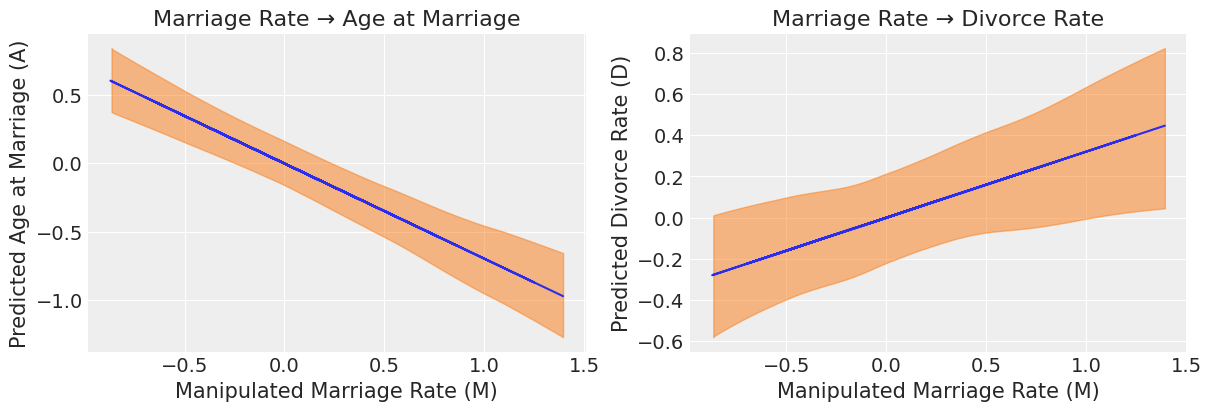

In [93]:
M_seq = data["Marriage_std"].values * 0.5  # or any defined M_seq you use

_, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot age at marriage vs. marriage rate
az.plot_hdi(M_seq, counterfactual.posterior_predictive["A_obs"], ax=ax[0])
ax[0].plot(M_seq, counterfactual.posterior_predictive["A_obs"].mean(dim=["chain", "draw"]))
ax[0].set_title("Marriage Rate → Age at Marriage")
ax[0].set_xlabel("Manipulated Marriage Rate (M)")
ax[0].set_ylabel("Predicted Age at Marriage (A)")

# Plot divorce rate vs. marriage rate
az.plot_hdi(M_seq, counterfactual.posterior_predictive["mu_D"], ax=ax[1])
ax[1].plot(M_seq, counterfactual.posterior_predictive["mu_D"].mean(dim=["chain", "draw"]))
ax[1].set_title("Marriage Rate → Divorce Rate")
ax[1].set_xlabel("Manipulated Marriage Rate (M)")
ax[1].set_ylabel("Predicted Divorce Rate (D)")


5H3.  Return to the milk energy model, m5.7. Suppose that the true causal relationship among the variables is: Image
Now compute the counterfactual effect on K of doubling M. You will need to account for both the direct and indirect paths of causation. Use the counterfactual example from the chapter (starting on page 140) as a template.

In [106]:
dcc

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082
10,New World Monkey,Cebuella pygmaea,0.80,41.35,20.85,37.80,0.12,58.85,0.980633,-1.461962,-0.589690
11,New World Monkey,Callimico goeldii,0.46,3.93,25.30,70.77,0.47,61.69,-1.125913,-0.986139,-0.575560
12,New World Monkey,Callithrix jacchus,0.71,38.38,20.09,41.53,0.32,60.32,0.423018,-1.215673,-0.581616
15,Old World Monkey,Miopithecus talpoin,0.68,40.15,18.08,41.77,1.55,69.97,0.237147,0.401118,-0.531960
17,Old World Monkey,M mulatta,0.97,55.51,13.17,31.32,3.24,70.41,2.033906,0.474837,-0.463734


In [95]:

with pm.Model() as m5_7_c:
    # Inputs (assumed standardized and loaded into shared variables)
    shared_M = shared(dcc["M"].values)

    # Step 1: N ~ M
    sigma_N = pm.Exponential("sigma_N", 1)
    bMN = pm.Normal("bMN", 0, 0.5)
    aN = pm.Normal("aN", 0, 0.2)
    mu_N = pm.Deterministic("mu_N", aN + bMN * shared_M)
    N_obs = pm.Normal("N_obs", mu_N, sigma_N, observed=dcc["N"])

    # Step 2: K ~ M + N
    sigma_K = pm.Exponential("sigma_K", 1)
    bMK = pm.Normal("bMK", 0, 0.5)
    bNK = pm.Normal("bNK", 0, 0.5)
    aK = pm.Normal("aK", 0, 0.2)
    mu_K = pm.Deterministic("mu_K", aK + bMK * shared_M + bNK * mu_N)
    K_obs = pm.Normal("K_obs", mu_K, sigma_K, observed=dcc["K"])

    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_N, bMN, aN, sigma_K, bMK, bNK, aK]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [107]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bMN,0.529,0.207,0.142,0.918,0.003,0.004,4315.0,2312.0,1.0
aN,-0.022,0.139,-0.295,0.220,0.002,0.002,4273.0,2988.0,1.0
bMK,-0.248,0.311,-0.840,0.320,0.005,0.005,4109.0,2958.0,1.0
bNK,-0.125,0.450,-0.977,0.704,0.007,0.006,4094.0,2871.0,1.0
aK,0.045,0.160,-0.248,0.353,0.002,0.003,4516.0,2976.0,1.0
sigma_N,0.848,0.163,0.573,1.145,0.003,0.003,4304.0,2829.0,1.0
sigma_K,1.062,0.198,0.712,1.418,0.003,0.004,4676.0,2647.0,1.0
mu_N[0],-0.295,0.180,-0.621,0.056,0.003,0.003,4131.0,2714.0,1.0
mu_N[1],-0.225,0.164,-0.519,0.097,0.003,0.003,4116.0,2886.0,1.0
mu_N[2],-0.222,0.163,-0.514,0.101,0.003,0.003,4117.0,2842.0,1.0


In [98]:
# double M
double_M = dcc["M"].values * 2.0
shared_M.set_value(double_M)

# Use posterior predictive sampling to simulate counterfactuals
with m5_7_c:
    counterfactual = pm.sample_posterior_predictive(trace, var_names=["mu_K", "mu_N", "N_obs"])

Sampling: [N_obs]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Text(0, 0.5, 'Milk kcal/g (standardized)')

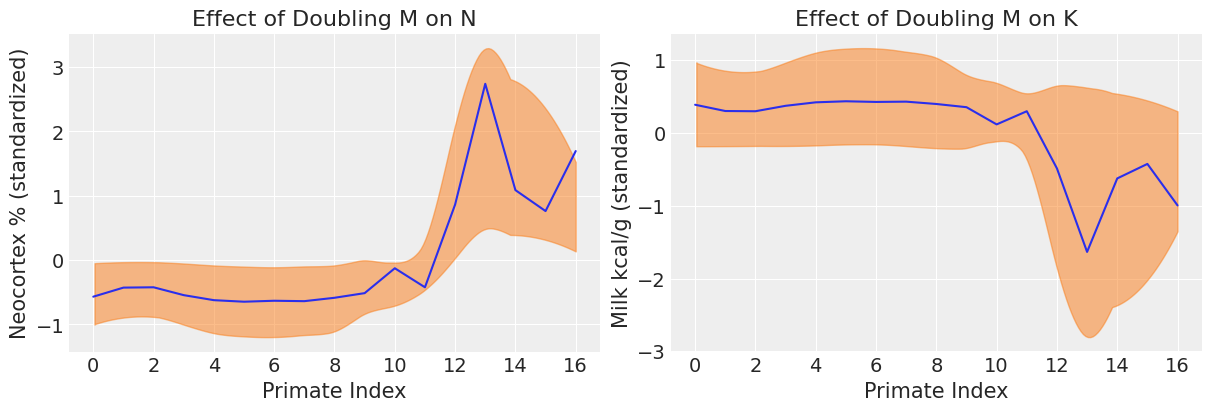

In [100]:
state_idx = np.arange(len(double_M))

_, ax = plt.subplots(1, 2, figsize=(12, 4))

# M → N
az.plot_hdi(state_idx, counterfactual.posterior_predictive["mu_N"], ax=ax[0])
ax[0].plot(state_idx, counterfactual.posterior_predictive["mu_N"].mean(dim=["chain", "draw"]))
ax[0].set_title("Effect of Doubling M on N")
ax[0].set_xlabel("Primate Index")
ax[0].set_ylabel("Neocortex % (standardized)")

# M → K
az.plot_hdi(state_idx, counterfactual.posterior_predictive["mu_K"], ax=ax[1])
ax[1].plot(state_idx, counterfactual.posterior_predictive["mu_K"].mean(dim=["chain", "draw"]))
ax[1].set_title("Effect of Doubling M on K")
ax[1].set_xlabel("Primate Index")
ax[1].set_ylabel("Milk kcal/g (standardized)")

In [101]:
bMN_samples = trace.posterior["bMN"].values.flatten()
bNK_samples = trace.posterior["bNK"].values.flatten()
bMK_samples = trace.posterior["bMK"].values.flatten()

# Indirect effect = M → N → K
indirect_effect = bMN_samples * bNK_samples

# Direct effect = M → K
direct_effect = bMK_samples

# Total effect = direct + indirect
total_effect = direct_effect + indirect_effect

Text(0.5, 1.0, 'Posterior distributions of direct, indirect, and total effects of M on K')

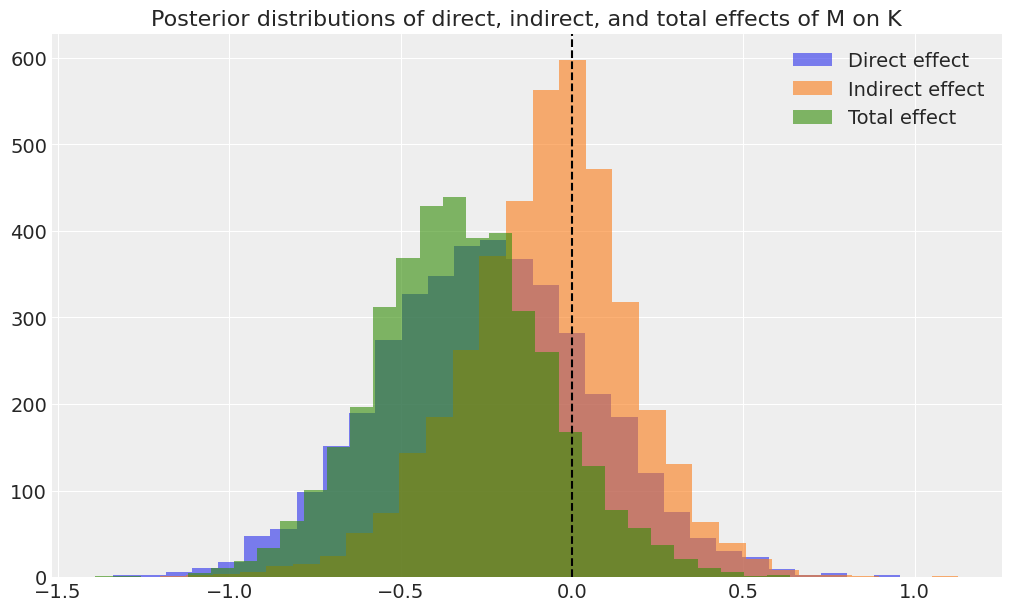

In [102]:
plt.figure(figsize=(10, 6))
plt.hist(direct_effect, bins=30, alpha=0.6, label="Direct effect")
plt.hist(indirect_effect, bins=30, alpha=0.6, label="Indirect effect")
plt.hist(total_effect, bins=30, alpha=0.6, label="Total effect")
plt.axvline(0, color="black", linestyle="--")
plt.legend()
plt.title("Posterior distributions of direct, indirect, and total effects of M on K")

C:\Users\risto\AppData\Local\Temp\ipykernel_13080\1855594999.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


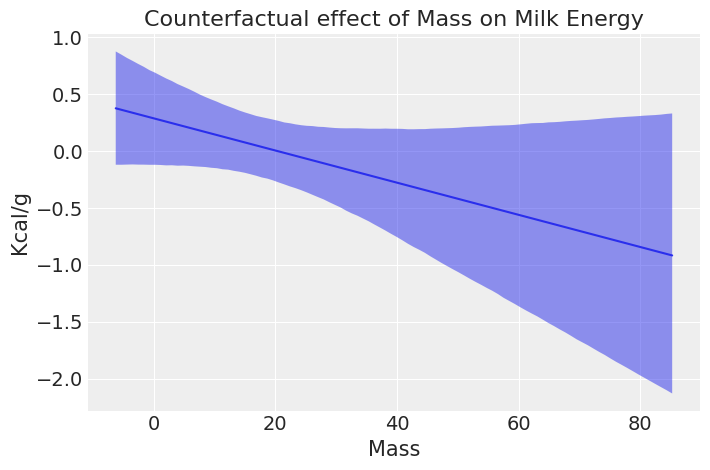

In [109]:
# Define a grid of M values (standardized mass)
M_seq = np.linspace(-1, 3, 100)

# Create empty array for K predictions
# shape: [n_M_vals, n_samples]
K_vals = []

for M_val in M_seq:
    # Step 1: simulate N for this M
    mu_N = (
        trace.posterior["aN"].values.flatten() +
        trace.posterior["bMN"].values.flatten() * M_val
    )

    # Step 2: plug N into K model
    mu_K = (
        trace.posterior["aK"].values.flatten() +
        trace.posterior["bMK"].values.flatten() * M_val +
        trace.posterior["bNK"].values.flatten() * mu_N
    )

    K_vals.append(mu_K)

# Convert to array: shape [n_M_vals, n_draws]
K_vals = np.array(K_vals)

# Unstandardize X-axis if needed (mass)
Mass = M_seq * np.std(dcc["mass"]) + np.mean(dcc["mass"])

# Now plot
plt.plot(Mass, K_vals.mean(axis=1))
plt.fill_between(
    Mass,
    np.quantile(K_vals, 0.055, axis=1),
    np.quantile(K_vals, 0.945, axis=1),
    alpha=0.5,
)
plt.xlabel("Mass")
plt.ylabel("Kcal/g")
plt.title("Counterfactual effect of Mass on Milk Energy")
plt.grid(True)
plt.tight_layout()
plt.show()


5H4.  Here is an open practice problem to engage your imagination. In the divorce date, States in the southern United States have many of the highest divorce rates. Add the South indicator variable to the analysis. First, draw one or more DAGs that represent your ideas for how Southern American culture might influence any of the other three variables (D, M or A). Then list the testable implications of your DAGs, if there are any, and fit one or more models to evaluate the implications. What do you think the influence of “Southerness” is?

I assume: 

    S
   ↙ ↓ ↘
  A → M → D
   ↘     ↑
     →   →
        D

S → A: cultural norms → earlier marriage age

S → M: possibly higher marriage rates in the South

S → D: possible direct influence due to social/economic factors

In [114]:
#data

In [115]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)
south_shared = shared(data["South"].values)

#age_shared = data["MedianAgeMarriage_std"].values

with pm.Model() as m_S_D:
    # S > D
    sigma = pm.Exponential("sigma", 1)
    bS = pm.Normal("bS", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bS * south_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    m_S_D_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


In [116]:
az.summary(m_S_D_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,0.515,0.254,0.042,0.995,0.004,0.004,3907.0,2984.0,1.0
a,-0.098,0.122,-0.326,0.135,0.002,0.002,3775.0,3081.0,1.0
sigma,0.966,0.101,0.787,1.157,0.001,0.002,4651.0,3063.0,1.0
mu[0],0.416,0.237,-0.020,0.868,0.004,0.004,4477.0,2791.0,1.0
mu[1],-0.098,0.122,-0.326,0.135,0.002,0.002,3775.0,3081.0,1.0
mu[2],-0.098,0.122,-0.326,0.135,0.002,0.002,3775.0,3081.0,1.0
mu[3],0.416,0.237,-0.020,0.868,0.004,0.004,4477.0,2791.0,1.0
mu[4],-0.098,0.122,-0.326,0.135,0.002,0.002,3775.0,3081.0,1.0
mu[5],-0.098,0.122,-0.326,0.135,0.002,0.002,3775.0,3081.0,1.0
mu[6],-0.098,0.122,-0.326,0.135,0.002,0.002,3775.0,3081.0,1.0


In [117]:
with pm.Model() as m_AS_D:
    # A + S > D
    sigma = pm.Exponential("sigma", 1)
    bS = pm.Normal("bS", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bS * south_shared + bA*age_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    m_AS_D_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, bA, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [118]:
az.summary(m_AS_D_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,0.342,0.224,-0.093,0.751,0.004,0.003,3386.0,3167.0,1.0
bA,-0.531,0.115,-0.745,-0.320,0.002,0.002,4211.0,3127.0,1.0
a,-0.071,0.109,-0.268,0.137,0.002,0.001,3434.0,3301.0,1.0
sigma,0.805,0.086,0.661,0.975,0.001,0.001,4010.0,3228.0,1.0
mu[0],0.592,0.206,0.193,0.973,0.003,0.003,5856.0,3131.0,1.0
mu[1],0.293,0.140,0.026,0.546,0.002,0.002,3188.0,3150.0,1.0
mu[2],0.037,0.114,-0.171,0.254,0.002,0.002,3256.0,3280.0,1.0
mu[3],1.019,0.241,0.558,1.471,0.003,0.004,6131.0,3507.0,1.0
mu[4],-0.390,0.123,-0.614,-0.153,0.002,0.002,4438.0,3184.0,1.0
mu[5],0.080,0.117,-0.140,0.297,0.002,0.002,3216.0,3279.0,1.0


In [119]:
with pm.Model() as m_MAS_D:
    # M + A + S > D
    sigma = pm.Exponential("sigma", 1)
    bS = pm.Normal("bS", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bS * south_shared + bA*age_shared + bM*marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    m_MAS_D_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, bA, bM, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [120]:
az.summary(m_MAS_D_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,0.345,0.229,-0.057,0.797,0.004,0.004,3292.0,2860.0,1.0
bA,-0.555,0.162,-0.848,-0.239,0.003,0.003,3258.0,2333.0,1.0
bM,-0.036,0.160,-0.332,0.275,0.003,0.003,3195.0,2599.0,1.0
a,-0.074,0.113,-0.279,0.145,0.002,0.002,3565.0,2906.0,1.0
sigma,0.813,0.087,0.653,0.970,0.002,0.001,3287.0,2629.0,1.0
mu[0],0.607,0.210,0.210,1.004,0.003,0.003,4304.0,2951.0,1.0
mu[1],0.252,0.222,-0.155,0.687,0.003,0.003,4041.0,3177.0,1.0
mu[2],0.038,0.119,-0.182,0.263,0.002,0.002,3480.0,2927.0,1.0
mu[3],0.995,0.269,0.499,1.506,0.004,0.004,4823.0,3504.0,1.0
mu[4],-0.397,0.128,-0.645,-0.163,0.002,0.002,3629.0,3261.0,1.0


In [121]:
with pm.Model() as m_S_A:
    # M + A + S > D
    sigma = pm.Exponential("sigma", 1)
    bS = pm.Normal("bS", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bS * south_shared)
    age = pm.Normal("age", mu, sigma, observed=data["MedianAgeMarriage_std"].values)

    m_S_A_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [122]:
az.summary(m_S_A_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,-0.356,0.255,-0.847,0.110,0.004,0.004,3659.0,2840.0,1.0
a,0.068,0.124,-0.157,0.311,0.002,0.002,3820.0,2963.0,1.0
sigma,0.992,0.101,0.806,1.176,0.001,0.002,5306.0,2931.0,1.0
mu[0],-0.288,0.238,-0.745,0.164,0.004,0.004,4572.0,3303.0,1.0
mu[1],0.068,0.124,-0.157,0.311,0.002,0.002,3820.0,2963.0,1.0
mu[2],0.068,0.124,-0.157,0.311,0.002,0.002,3820.0,2963.0,1.0
mu[3],-0.288,0.238,-0.745,0.164,0.004,0.004,4572.0,3303.0,1.0
mu[4],0.068,0.124,-0.157,0.311,0.002,0.002,3820.0,2963.0,1.0
mu[5],0.068,0.124,-0.157,0.311,0.002,0.002,3820.0,2963.0,1.0
mu[6],0.068,0.124,-0.157,0.311,0.002,0.002,3820.0,2963.0,1.0


In [123]:
with pm.Model() as m_AS_M:
    # M ~ A + S
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bS = pm.Normal("bS", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bS * south_shared)
    marriage = pm.Normal("marriage", mu, sigma, observed=data["Marriage_std"].values)

    m_AS_M_trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bS, a]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [124]:
az.summary(m_AS_M_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.712,0.103,-0.911,-0.525,0.001,0.002,4716.0,3261.0,1.0
bS,-0.165,0.200,-0.561,0.192,0.004,0.003,2964.0,2884.0,1.0
a,0.041,0.099,-0.137,0.231,0.002,0.002,3431.0,3188.0,1.0
sigma,0.711,0.074,0.580,0.852,0.001,0.001,4497.0,2611.0,1.0
mu[0],0.308,0.179,-0.027,0.655,0.002,0.003,5549.0,3422.0,1.0
mu[1],0.530,0.127,0.293,0.769,0.002,0.002,3302.0,2990.0,1.0
mu[2],0.186,0.103,0.001,0.385,0.002,0.002,3281.0,3303.0,1.0
mu[3],0.881,0.209,0.497,1.288,0.003,0.003,6829.0,3294.0,1.0
mu[4],-0.387,0.111,-0.593,-0.183,0.002,0.002,4527.0,3252.0,1.0
mu[5],0.243,0.106,0.036,0.432,0.002,0.002,3258.0,3238.0,1.0


array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

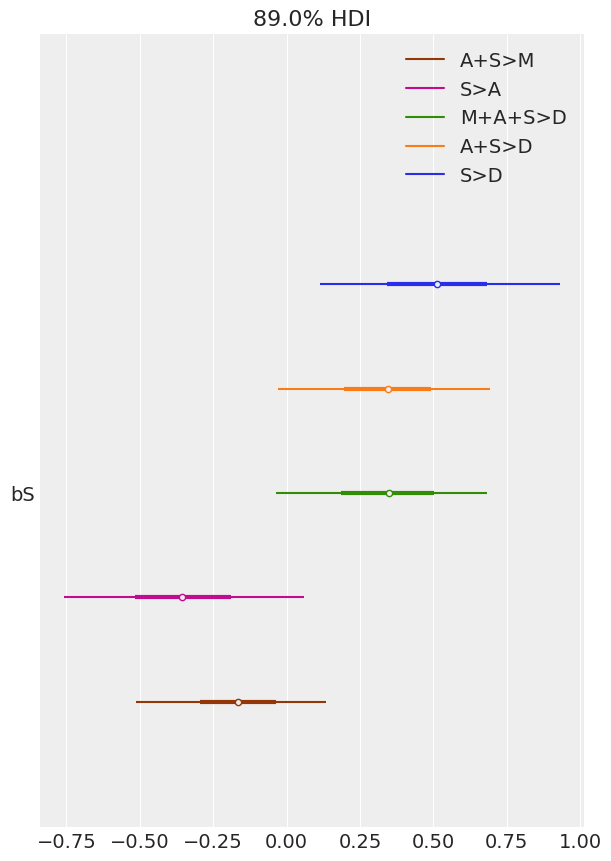

In [129]:
az.plot_forest(
    [m_S_D_trace, m_AS_D_trace, m_MAS_D_trace, m_S_A_trace, m_AS_M_trace],
    model_names=["S>D", "A+S>D", "M+A+S>D", "S>A", "A+S>M"],
    var_names=["bS"],
    combined=True,
    hdi_prob =.89

)

Only in the simple model S → D does the effect of Southerness appear clearly positive. When we control for age at marriage and marriage rate, this effect is no longer credibly distinct from zero. This suggests that southern states may have higher divorce rates, but the association is likely explained by other mediating factors. The models do not show strong evidence that southern states differ consistently in marriage age or marriage rate.

In [80]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jul 09 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

arviz     : 0.12.1
numpy     : 1.22.1
pymc      : 4.0.0
pandas    : 1.4.2
matplotlib: 3.5.2
scipy     : 1.7.3
daft      : 0.1.2

Watermark: 2.3.1

